# Load Variance Problem
## Import Dependencies

In [82]:
# Autoreload Magic to autoreload external modules
%load_ext autoreload
%autoreload 2

# Numpy and Scipy
import numpy as np
import scipy
import scipy.io

from numpy import inf
from numpy.linalg import norm
from optalg.opt_solver import *

# Gridopt, PFNET and MP-PFNET
import gridopt
import pfnet
import mppfnet
from mppfnet.mp_network import MPNetwork
from mppfnet.mp_problem import MPProblem
import pfvis

# Python Multiprocessing
import multiprocessing

# Matplotlib and Seaborn
from matplotlib import rcParams
from matplotlib.pyplot import clf, plot, title, xlabel, ylabel, legend, show, spy
%matplotlib inline
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_format='svg'
rcParams['figure.figsize'] = 10, 4
import seaborn

# CVXPY
import cvxpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Construct Problem

In [83]:
mp = MPNetwork(timesteps=24)
mp.load('./data/case32.art')

In [84]:
prices = scipy.io.loadmat('./data/eex_intraday_2010_3600s.mat')['eex_intraday_2010_3600s']
eex_prices = np.array([p[0,0] for p in prices[:, 5][1:]]) * mp.base_power 
mp.set_prices(eex_prices)

In [85]:
mp.load_load_profile_from_csv("./data/Electricity_Profile.csv")

In [86]:
mp.generate_solar_profiles()

In [87]:
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_E)
mp.set_flags(pfnet.OBJ_BAT, pfnet.FLAG_VARS,pfnet.BAT_PROP_ANY, pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_LOAD, pfnet.FLAG_VARS,pfnet.LOAD_PROP_ANY, pfnet.LOAD_VAR_P)
mp.set_flags(pfnet.OBJ_LOAD, pfnet.FLAG_FIXED,pfnet.LOAD_PROP_ANY, pfnet.LOAD_VAR_P)
mp.set_flags(pfnet.OBJ_VARGEN, pfnet.FLAG_VARS, pfnet.VARGEN_PROP_ANY, pfnet.VARGEN_VAR_P)
mp.set_flags(pfnet.OBJ_VARGEN, pfnet.FLAG_FIXED, pfnet.VARGEN_PROP_ANY, pfnet.VARGEN_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_P)
mp.set_flags(pfnet.OBJ_BAT,pfnet.FLAG_BOUNDED,pfnet.BAT_PROP_ANY,pfnet.BAT_VAR_E)

In [88]:
p = MPProblem(mp)

In [89]:
p.add_function(pfnet.FUNC_TYPE_NETCON_COST, 1.0)

In [90]:
p.add_constraint(pfnet.CONSTR_TYPE_LBOUND)
p.add_constraint(pfnet.CONSTR_TYPE_FIX)
p.add_constraint(mppfnet.CONSTR_TYPE_BAT_DYN)

In [91]:
p.analyze()
x = p.get_init_point()
x = p.eval(x)

## Higher Load Profile Penality $\gamma = 10$

The state vector reads as:
$x = (x (0), \ldots, x(T))$

with $x(t) = (x_0 (t), \ldots, x_n (t))$

In [92]:
x = cvxpy.Variable(mp.get_network().num_vars * mp.timesteps)

Tuning parameter $\gamma$ that scales the penalty of a spiky load profile. A lower $\gamma$ corresponds to a less spiky load profile.

In [93]:
gamma = 100

linear energy cost: $\sum_t^T \sum_i \bar f_i(t, x_i) = \sum_i c_i^\top x_i$

In [94]:
g = p.gphi #/ mp.base_power
cost_scaling_factor = np.maximum(norm(g, ord=inf), 1)
g = g / cost_scaling_factor
energy_cost_obj = g.T * x # energy cost

In [95]:
net_power = np.empty(mp.timesteps, dtype='object')
# the constant part of the power injection is the load and the vargen input
constant_powers = np.zeros((mp.timesteps, mp.get_network().num_buses - 1), dtype='object')
# expressions for the injected power at time t at bus i
power = np.empty(shape=(mp.timesteps, mp.get_network().num_buses - 1), dtype='object')
for t in range(0, mp.timesteps):
    for bus_i in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):        
        i = bus_i.index
        # constant parts of the injected power (load and vargens)
        constant_powers[t, i] = sum([x[t * mp.get_network().num_vars + load.index_P] for load in mp.get_network(time=t).get_bus(i).loads])
        constant_powers[t, i] -= sum([x[t * mp.get_network().num_vars + vargen.index_P] for vargen in mp.get_network(time=t).get_bus(i).vargens]) # vargen power
        power_i_t  = constant_powers[t, i]
        # parts of the injected power that are optimization variables
        power_i_t  -= sum([x[t * mp.get_network().num_vars + gen.index_P] for gen in mp.get_network(time=t).get_bus(i).gens]) # gen power
        power_i_t  += sum([x[t * mp.get_network().num_vars + bat.index_Pc] for bat in mp.get_network(time=t).get_bus(i).bats]) # battery charge
        power_i_t  -= sum([x[t * mp.get_network().num_vars + bat.index_Pd] for bat in mp.get_network(time=t).get_bus(i).bats]) # battery discharge
        power[t, i] = power_i_t
    # the net power is the sum other all buses at a time t
    net_power[t] = sum(power[t, :])
   

the smoothing penality term is defined as:
$$\nu (x)  = \sum_{t}^{T} (p (t, x) - p(t-1, x))^2$$

with
$$p(t, x) = \sum_i p_i (t, x) = \sum_i (l_i (t) - r_i (t) - p_{g, i} (t, x) + p_{b, i} (t, x)) $$

In [96]:
profile_smothing_obj = sum([cvxpy.square(net_power[t] - net_power[t-1]) for t in range(1, mp.timesteps)])

$$f(x) = \gamma  \nu (x) + \sum_t^T \sum_i \bar f_i(t, x_i)$$

In [97]:
objective = cvxpy.Minimize(gamma * profile_smothing_obj + energy_cost_obj)

s.t.

battery dynamics $$A x = b$$

In [98]:
constraints = [p.A * x == p.b]

linear bounds $$l \le x \le u$$

In [99]:
constraints += [ p.l <= x, x <= p.u]

In [100]:
problem = cvxpy.Problem(objective, constraints)

In [101]:
problem.solve()

11.563271420574665

Total penality for load profile spikes $\nu (x^*)$

In [102]:
profile_smothing_obj.value

0.06525096772625674

Total energy cost objective $\sum_t^T \bar f (x^*)$:

In [103]:
energy_cost_obj.value * cost_scaling_factor

5.0381746470962874

### Map Solution

Save (centralized) solution as $x^*$ and update model

In [104]:
xstar = np.array(x.value).flatten()
mp.set_var_values(np.array(x.value).flatten())
mp.update_properties()

### Display Results

$p_b (t)$: power injected by the batteries

In [105]:
p_b  = np.fromiter([sum(bat.P for bat in net.batteries) for t, net in mp.networks.items()], np.float)

$l (t)$: power consumer by the loads

In [106]:
l  = np.fromiter([sum(load.P for load in net.loads) for t, net in mp.networks.items()], np.float)

$p_g (t)$: power injected by the (non-slack) generators

In [107]:
p_g = np.fromiter([sum(- gen.P for gen in net.generators) for t, net in mp.networks.items()], np.float)

$r (t)$: power injected by the renewable generation

In [108]:
r  = np.fromiter([sum(- gen.P for gen in net.var_generators) for t, net in mp.networks.items()], np.float)

$p (t)$: net power injection

In [109]:
p_net  = np.fromiter([net_power[t] if isinstance(net_power[t], float) else net_power[t].value for t, net in mp.networks.items()], np.float)

$\delta p  = p(t) - p(t-1)$: change in net power injection

In [110]:
dp_net = np.fromiter([p_net[t] - p_net[t-1] for t in range(mp.timesteps)], np.float)

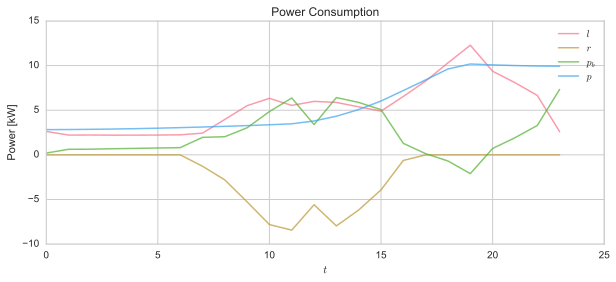

In [111]:
clf()
seaborn.set_style("whitegrid")

plot(l * mp.base_power * 1e3, label="$l$", color=seaborn.color_palette("husl")[0],alpha=0.7, lw=1.5)
#plot(p_g, label="$p_g$")
plot(r * mp.base_power * 1e3, label="$r$", color=seaborn.color_palette("husl")[1], alpha=0.7, lw=1.5)
plot(p_b * mp.base_power * 1e3, label="$p_b$", color=seaborn.color_palette("husl")[2], alpha=0.7,lw=1.5)
plot(p_net * mp.base_power * 1e3, label="$p$", color=seaborn.color_palette("husl")[4],alpha=0.7,lw=1.5)
#plot(dp_net, label="$\delta p$ ")
title("Power Consumption")
xlabel("$t$")
ylabel("Power [kW]")

legend()
show()

Energy Cost $f(x^*)$

In [112]:
energy_cost_obj.value * cost_scaling_factor

5.0381746470962874

Load profile penalty $\nu (x^*)$

In [113]:
profile_smothing_obj.value

0.06525096772625674

## Lower Load Profile Penalty $\gamma = 0.5$

In [114]:
gamma = 5e-1

In [115]:
objective = cvxpy.Minimize(gamma * profile_smothing_obj + energy_cost_obj)
problem_2 = cvxpy.Problem(objective, constraints)
problem_2.solve()

3.5522227883469863

Energy Cost $f(x^*)$

In [116]:
energy_cost_obj.value * cost_scaling_factor

3.2869667786458017

Load profile penalty $\nu (x^*)$

In [117]:
profile_smothing_obj.value

0.5305120190139916

### Map Solution

Save (centralized) solution as $x^*$ and update model

In [118]:
xstar = np.array(x.value).flatten()
mp.set_var_values(np.array(x.value).flatten())
mp.update_properties()

### Display Results

$p_b (t)$: power injected by the batteries

In [119]:
p_b  = np.fromiter([sum(bat.P for bat in net.batteries) for t, net in mp.networks.items()], np.float)

$l (t)$: power consumer by the loads

In [120]:
l  = np.fromiter([sum(load.P for load in net.loads) for t, net in mp.networks.items()], np.float)

$p_g (t)$: power injected by the (non-slack) generators

In [121]:
p_g = np.fromiter([sum(- gen.P for gen in net.generators) for t, net in mp.networks.items()], np.float)

$r (t)$: power injected by the renewable generation

In [122]:
r  = np.fromiter([sum(- gen.P for gen in net.var_generators) for t, net in mp.networks.items()], np.float)

$p (t)$: net power injection

In [123]:
p_net  = np.fromiter([net_power[t] if isinstance(net_power[t], float) else net_power[t].value for t, net in mp.networks.items()], np.float)

$\delta p  = p(t) - p(t-1)$: change in net power injection

In [124]:
dp_net = np.fromiter([p_net[t] - p_net[t-1] for t in range(mp.timesteps)], np.float)

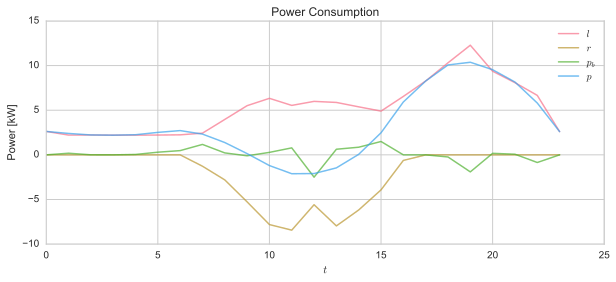

In [125]:
clf()
seaborn.set_style("whitegrid")

plot(l * mp.base_power * 1e3, label="$l$", color=seaborn.color_palette("husl")[0],alpha=0.7, lw=1.5)
#plot(p_g, label="$p_g$")
plot(r * mp.base_power * 1e3, label="$r$", color=seaborn.color_palette("husl")[1], alpha=0.7, lw=1.5)
plot(p_b * mp.base_power * 1e3, label="$p_b$", color=seaborn.color_palette("husl")[2], alpha=0.7,lw=1.5)
plot(p_net * mp.base_power * 1e3, label="$p$", color=seaborn.color_palette("husl")[4],alpha=0.7,lw=1.5)
#plot(dp_net, label="$\delta p$ ")
title("Power Consumption")
xlabel("$t$")
ylabel("Power [kW]")

legend()
show()

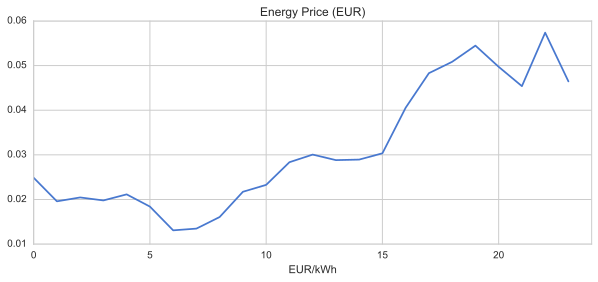

In [126]:
pfvis.plot_energy_price(mp)

# Plots

## Load Profile

In [46]:
%aimport pfvis
%aimport ipyplots

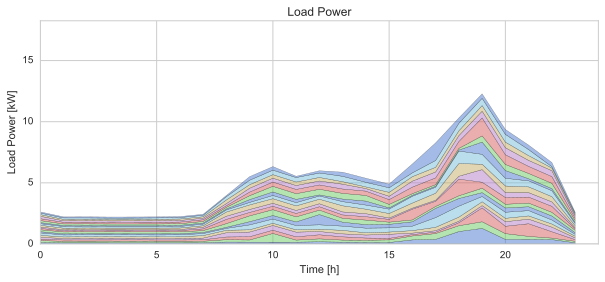

In [47]:
pfvis.plot_load_power(mp)

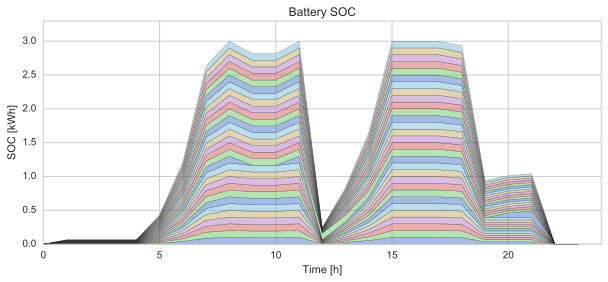

In [48]:
pfvis.plot_battery_soc(mp)

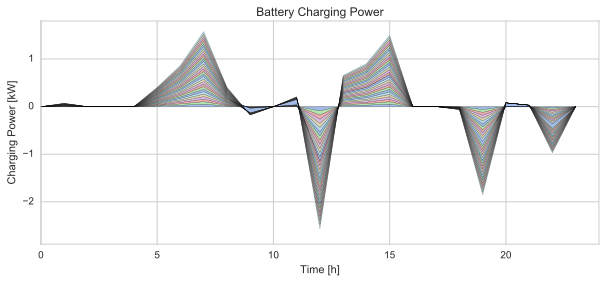

In [49]:
pfvis.plot_battery_power(mp)

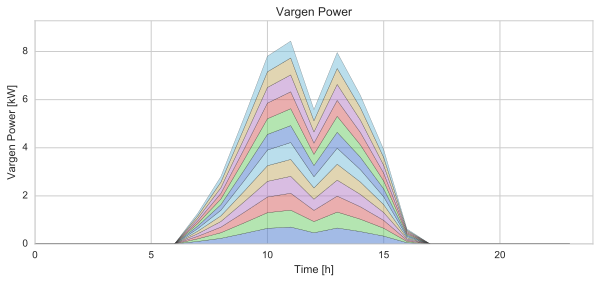

In [50]:
pfvis.plot_vargen_injection(mp)

# Distributed Problem

Construct Projection Matrices

In [51]:
(sim_p_mats, sim_p_ang, sim_p_x) = mp.get_projection_matrix(mp.get_network().buses)

Construct Variable fixing constraints

In [52]:
Afix = scipy.sparse.block_diag([problem.find_constraint(pfnet.CONSTR_TYPE_FIX).A for problem in p.problems.values()])
bfix = np.hstack([problem.find_constraint(pfnet.CONSTR_TYPE_FIX).b for problem in p.problems.values()])
a_fix = dict()
b_fix = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    a_fix[bus.index] = Afix * sim_p_mats[bus.index].T
    b_fix[bus.index] = bfix

Projection matrix $P_{f, i}$ for variable fixing constraints

In [55]:
p_fix = dict()

for index, a in a_fix.items():
    bus = net.get_bus(index)
    rows = []
    cols = []
    data = []
    for n, i in enumerate(np.nonzero(a_fix[index])[0]):
        rows += [n]
        cols += [i]
        data += [1]
    p_fix[index] = scipy.sparse.coo_matrix((data, (rows, cols)), shape=(mp.timesteps * (len(bus.loads) + len(bus.vargens)), mp.timesteps * (net.num_loads + net.num_vargens)))
        

Construct battery constraints for the individual buses

In [53]:
net = mp.get_network()
a_bats = dict()

for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        a_bats[bus.index] = scipy.sparse.vstack([p.get_battery_A(bat) * sim_p_mats[bus.index].T for bat in bus.bats])
    else:
        a_bats[bus.index] = scipy.sparse.coo_matrix(([], ([], [])), shape=(0, sim_p_mats[bus.index].T.shape[1]))
b_bats = dict()
for bus in filter(lambda bus: (not bus.is_slack()), net.buses):
    if bus.bats:
        b_bats[bus.index] = np.hstack([p.get_battery_b(bat) for bat in bus.bats])   
    else:
        b_bats[bus.index] = np.array([])  

Project local variable fixing constraints $A_{f, i}, b_{f, i}$

In [56]:
for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):
    if p_fix[bus.index].shape[0] > 0:
        a_fix[bus.index] = p_fix[bus.index] * a_fix[bus.index]
        b_fix[bus.index] = p_fix[bus.index] * b_fix[bus.index]
    else:
        a_fix[bus.index] = None
        b_fix[bus.index] = None

Construct linear bounds for the individual buses

In [54]:
l_mats = {bus.index: sim_p_mats[bus.index] * p.l for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}
u_mats = {bus.index: sim_p_mats[bus.index] * p.u for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}

Construct (seperable) energy cost functions

In [57]:
g_mats = {bus.index: sim_p_mats[bus.index] * g for bus in filter(lambda bus: (not bus.is_slack()), net.buses)}

Construct (seperable subproblems $0, \ldots, n$)

In [58]:
dist_problems = dict()
local_energy_cost_obj = np.zeros(mp.get_network().num_buses, dtype='object')
local_objective = np.zeros(mp.get_network().num_buses, dtype='object')
local_constraints = dict()

for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses):
    i = bus.index
    num_var = g_mats[i].shape[0]
    x_i = sim_p_mats[i] * x
    # check that x_i has the right dimensions
    assert(x_i.size[0] == num_var)
    
    # local constraints
    local_constraints[i] = [l_mats[i] <= x_i, x_i <= u_mats[i], a_bats[i] * x_i == b_bats[i]]
    if a_fix[i] is not None:
        local_constraints[i] += [a_fix[i] * x_i == b_fix[i]]
    
    # local objective
    local_energy_cost_obj[i] = g_mats[i].T * x_i 
    local_objective[i] = cvxpy.Minimize( local_energy_cost_obj[i])
    
    dist_problems[i] = cvxpy.Problem(local_objective[i], local_constraints[i])

Create problem with non-seperable objective (the load profile penalty)

In [127]:
non_seperable = cvxpy.Problem(cvxpy.Minimize(gamma * profile_smothing_obj))

Solve sum of problems

In [128]:
(sum([prob for prob in dist_problems.values()]) + non_seperable).solve()

5.660832800367126

Energy Cost

In [129]:
sum([local_energy_cost_obj[bus.index].value for bus in filter(lambda bus: (not bus.is_slack()), mp.get_network().buses)]) * cost_scaling_factor

5.6608328000233197

Calculate $H$

In [130]:
rows = []
cols = []
data = []

def get_p_t(t):
    p_t = np.zeros((mp.num_vars, ))
    
    for bat in mp.get_network().batteries:
        p_t[t * nx + bat.index_Pc] = 1
        p_t[t * nx + bat.index_Pd] = -1
        
    for load in mp.get_network().loads:        
        p_t[t * nx + load.index_P] = 1
    for gen in mp.get_network().var_generators:        
        p_t[t * nx + gen.index_P] = -1
        
    return p_t

H = np.zeros((mp.num_vars, mp.num_vars))
nx = mp.get_network().num_vars
obj_v = 0.0
for t in range(1, mp.timesteps):
    p_t = scipy.sparse.coo_matrix(np.matrix(get_p_t(t)).T)
    p_tpre = scipy.sparse.coo_matrix(np.matrix(get_p_t(t-1)).T)
    H += (p_t * p_t.T) -  (p_tpre * p_t.T)  - (p_t * p_tpre.T) + (p_tpre * p_tpre.T)

Compare objective value from distributed cost and centralized cost

In [134]:
objective_value * gamma

matrix([[ 0.]])

In [135]:
non_seperable.objective.value

0.0

In [136]:
 (x.value.T * H * x.value) * gamma

matrix([[ 0.]])